# [1]. Reading Data

Taken help from https://github.com/krpiyush5/Amazon-Fine-Food-Review/blob/master/10%20Amazon%20Fine%20Food%20Reviews%20Analysis_Clustering.ipynb for word cloud printing as this is the only peice of code i was able to understand
also
https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/DBSCAN.ipynb

Let me copy code from my previous assignment where we are doing preprocessing steps like deduplication,removal of stop words, decontraction of words,lemmatization etc.

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
cd drive/My\ Drive

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [45]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from tqdm import tqdm
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:

#con = sqlite3.connect(r"D:\AppliedAI\AAIC_Course_handouts\11_Amazon Fine Food Reviews\amazon-fine-food-reviews\database.sqlite")
con = sqlite3.connect(r"database.sqlite")
data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""",con)
#data = pd.read_csv(""" SELECT * FROM Reviews WHERE Score != 3""",con)

# Change Score with 1 n 2 as -ve and 4 n 5 as +ve

def chng_to_0_or_1 (Score):
    if Score ==4 or Score ==5:
        return 1
    elif Score ==1 or Score ==2:
        return 0
    else:# Thus in case by some mistake any data is their with rating 6 or 7 etc due to some error is removed
        pass
currentScore = data["Score"]
new_Score = currentScore.map(chng_to_0_or_1)
data["Score"] = new_Score
print ("Number of data points available")
print (data.shape)#Gives original number of data points available


#2 Data Cleaning a.) Getting rid of duplicates and b.) if helpnessdenominator < helpfulnessnumerator


data = data.drop_duplicates(subset = ["UserId","ProfileName","HelpfulnessNumerator","HelpfulnessDenominator","Score","Time","Summary","Text"], keep='first', inplace=False)
print ("Number of data points after removing duplicates")
print (data.shape)#Gives data points are deduplication

# Reference: Copied from above cell  final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
data=data[data.HelpfulnessNumerator<=data.HelpfulnessDenominator]
print ("Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator ")
print (data.shape)

#3 Preprocessing begins

#Convert to lower case,convert shortcut words to proper words, remove Special Character

#i) Convert to lower case:
data["Text"] =  (data["Text"].str.lower())
data["Summary"] =  (data["Summary"].str.lower())

#ii) Convert Shortcuts words to proper words
#List of Words are:https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions
#Reference:https://stackoverflow.com/questions/39602824/pandas-replace-string-with-another-string
data['Text'] = data['Text'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
##############Lets do the same for summary Text##################################
data['Summary'] = data['Summary'].replace({"ain't":"am not","amn't":"am not","aren't":"are not", \
"can't":"cannot","cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have", \
"daren't":"dare not","daresn't":"dare not","dasn't":"dare not","didn't":"did not","doesn't":"does not", \
"don't":"do not","e'er":"ever","everyone's":"everyone is","finna":"fixing to","gimme":"give me", \
"gonna":"going to","gon't":"go not","gotta":"got to","hadn't":"had not","hasn't":"has not","haven't":"have not",\
"he'd":"he had","he'll":"he shall","he's":"he has","he've":"he have","how'd":"how did","how'll":"how will",\
"how're":"how are","how's":"how has","I'd":"I had","I'll":"I shall","I'm":"I am","I'm'a":"I am about to",\
"I'm'o":"I am going to","I've":"I have","isn't":"is not","it'd":"it would","it'll":"it shall","it's":"it has",\
"let's":"let us","mayn't":"may not","may've":"may have","mightn't":"might not","might've":"might have",\
"mustn't":"must not","mustn't've":"must not have","must've":"must have","needn't":"need not","ne'er":"never",\
"o'clock":"of the clock","o'er":"","ol'":"old","oughtn't":"ought not","shalln't":"shall not","shan't":"shall not",\
"she'd":"she had","she'll":"she shall","she's":"she is","should've":"should have","shouldn't":"should not",\
"shouldn't've":"should not have","somebody's":"somebody has","someone's":"someone has","something's":"something has",\
"that'll":"that will","that're":"that are","that's":"that is","that'd":"that would","there'd":"there had",\
"there'll":"there shall","there're":"there are","there's":"there is","these're":"hese are","they'd":"they had",\
"they'll":"they will","they're":"they are","they've":"they have","this's":"","those're":"those are","tis":"it is",\
"twas":"it was","wasn't":"was not","we'd":"we had","we'd've":"we would have","we'll":"we will","we're":"we are",\
"we've":"we have","weren't":"were not","what'd":"what did","what'll":"what will","what're":"what are","what's":"what is",\
"what've":"what have","when's":"when is","where'd":"where did","where're":"where are","where've":"where have",\
"which's":"which has","who'd":"who would","who'd've":"who would have","who'll":"who shall","who're":"who are",\
"who's":"who has","who've":"who have","why'd":"why did","why're":"why are","why's":"why has","won't":"will not",\
"would've":"would have","wouldn't":"would not","y'all":"you all","you'd":"you had","you'll":"you shall","you're":"you are",\
"you've":"you have"})
########################################################################################
# iii) Remove Special Characters except alpahbets and numbers
#The reason i dont want to remove number people might write got five eggs as 5 eggs or vice versa and dont want to lose 
#that information which could be useful
#Ref:https://stackoverflow.com/questions/33257344/how-to-remove-special-characers-from-a-column-of-dataframe-using-module-re
data["Text"]=data["Text"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))
data["Summary_copy"]=data["Summary"].map(lambda x: re.sub(r'[^a-zA-Z_0-9 -]', '', x))

#The Summary are usually so small if we remove few stopwords the meaning itself would be complely lost or chamge
# So let us see what all stopwords we have
#Ref:::::::::https://stackoverflow.com/questions/5511708/adding-words-to-nltk-stoplist
#https://chrisalbon.com/machine_learning/preprocessing_text/remove_stop_words/

stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['would','could','br','<br>','<','>']
notstopwords = ['not','no','nor']
stopwords.extend(newStopWords)
stopwords = [word for word in stopwords if word not in notstopwords]

#  iv) For now let us just go with flow will use default stopwords as creating our own stop words is very time consuming
#Rather will use n-gram stratergy to get rid of problem of stopwords removal changing the meaning of sentences
#Ref:https://stackoverflow.com/questions/43184364/python-remove-stop-words-from-pandas-dataframe-give-wrong-output
data["New_Text"]= data['Text'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])
data["Summary"]= data['Summary_copy'].apply(lambda x: [item for item in str.split(x) if item not in stopwords])

#Ref:https://stackoverflow.com/questions/37347725/converting-a-panda-df-list-into-a-string/37347837
#we are creating new column New_summary so in case in future we need summary it is intact
data["New_Text"]=data["New_Text"].apply(' '.join)
data["Summary"]=data["Summary"].apply(' '.join)

# v) Now lets do Stemming
#https://stackoverflow.com/questions/48617589/beginner-stemming-in-pandas-produces-letters-not-stems
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
data["New_Text"] = data["New_Text"].apply(english_stemmer.stem)
data["Summary"] = data["Summary"].apply(english_stemmer.stem)
data["New_Text"] = data["New_Text"].astype(str)
data["Summary"] = data["Summary"].astype(str)

#vi) stemming without removing stop words
english_stemmer=SnowballStemmer('english', ignore_stopwords=True)
#https://stackoverflow.com/questions/34724246/attributeerror-float-object-has-no-attribute-lower
data["Text_with_stop"]=data["Text"].astype(str)
data["Summary"]=data["Summary"].astype(str)
data["Text_with_stop"]=data["Text_with_stop"].str.lower().map(english_stemmer.stem)
data["Summary"]=data["Summary"].str.lower().map(english_stemmer.stem)
data["Text_with_stop"]=data["Text_with_stop"].apply(''.join)
data["Summary"]=data["Summary"].apply(''.join)
data["Text_with_stop"] = data["Text_with_stop"].astype(str)
data["Summary"] = data["Summary"].astype(str)
print(data["Score"].value_counts())
print ("Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced \
dataset we first copy negative dataset 6 times than we sample with same number of times as positive")
# Let include another feature which is the length of the text 
data_neg = data[data["Score"] == 0]
data_pos = data[data["Score"] == 1]
data = pd.concat([data_pos,data_neg])
#https://stackoverflow.com/questions/46429033/how-do-i-count-the-total-number-of-words-in-a-pandas-dataframe-cell-and-add-thos
data["Text_length"]= (data["New_Text"].str.count(' ') + 1)
data["Summary_length"]= (data["Summary"].str.count(' ') + 1)
data["Time_formatted"]= pd.to_datetime(data["Time"])
data.sort_values(by=['Time_formatted'], inplace=True)

Number of data points available
(525814, 10)
Number of data points after removing duplicates
(366392, 10)
Number of data points after removing where HelpfulnessNumerator is more than HelpfulnessDenominator 
(366390, 10)
1    308679
0     57711
Name: Score, dtype: int64
Thus we see there are 85% and 15% positive and negative reviews,thus a unbalanced dataset.So to create a balanced dataset we first copy negative dataset 6 times than we sample with same number of times as positive


Now in actual scenario of Clustering we should not be having ground truth or yi's . So we should drop "Score" column and then check if our algorithm like K means etc is able to give results. 

Let us keep "data" frame intact so incase something gets corrupted we can resuse it. We will create a new dataframe without "Score" column named "newdata"

In [0]:
#newdata=data.drop(columns=['Score'])
newdata = data

Let us just last 50k (Latest) reviews as per the assignment for K means we need to use 50K reviews for K Means assignment and 5k for agglomerative and DBSCAN

In [0]:
newdata_50K = data.tail(50000)
newdata_50K.sort_values(by=['Time_formatted'], inplace=True)

newdata_5K = data.tail(5000)
newdata_5K.sort_values(by=['Time_formatted'], inplace=True)

In [0]:
X_no_stop_50k_reviews = newdata_50K['New_Text'].values

X_no_stop_5k_reviews = newdata_5K['New_Text'].values


# [4] Featurization

## [4.1] BAG OF WORDS

In [18]:
%time
from sklearn.feature_extraction.text import CountVectorizer
import math

bow_vect_50K = CountVectorizer(min_df = 7,max_features=9000)
bow_X_no_stop_50k_reviews = bow_vect_50K.fit_transform(X_no_stop_50k_reviews)
#bow_X_summary_50k = bow_vect.fit_transform(X_summary_50k)
#bow_X_no_stop_5k_reviews = bow_vect.fit_transform(X_no_stop_5k_reviews)
#bow_X_summary_5k = bow_vect.fit_transform(X_summary_5k)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs


In [19]:
features = bow_vect_50K.get_feature_names()
print (len(features))

9000


In [20]:
print("the shape of out text BOW vectorizer using 50K reviews",bow_X_no_stop_50k_reviews.get_shape())
#print("the shape of out summary BOW vectorizer using 50K reviews ",bow_X_summary_50k.get_shape())
#print("the shape of out text BOW vectorizer using 5K reviews",bow_X_no_stop_5k_reviews.get_shape())
#print("the shape of out summary BOW vectorizer using 5K reviews",bow_X_summary_5k.get_shape())


the shape of out text BOW vectorizer using 50K reviews (50000, 9000)


In [21]:
#BoW
"""
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])
"""

'\ncount_vect = CountVectorizer() #in scikit-learn\ncount_vect.fit(preprocessed_reviews)\nprint("some feature names ", count_vect.get_feature_names()[:10])\nprint(\'=\'*50)\n\nfinal_counts = count_vect.transform(preprocessed_reviews)\nprint("the type of count vectorizer ",type(final_counts))\nprint("the shape of out text BOW vectorizer ",final_counts.get_shape())\nprint("the number of unique words ", final_counts.get_shape()[1])\n'

Let us also standarize the data to be on safer side

In [0]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

bow_X_no_stop_50k_reviews_std =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_no_stop_50k_reviews)
#bow_X_summary_50k_std =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_50k)
#bow_X_no_stop_5k_reviews_std =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_no_stop_5k_reviews)
#bow_X_summary_5k_std =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_5k)

In [23]:
print("the shape of out text BOW vectorizer using 50K reviews after standarization",bow_X_no_stop_50k_reviews_std.get_shape())
#print("the shape of out summary BOW vectorizer using 50K reviews after standarization",bow_X_summary_50k_std.get_shape())
#print("the shape of out text BOW vectorizer using 5K reviews after standarization",bow_X_no_stop_5k_reviews_std.get_shape())
#print("the shape of out summary BOW vectorizer using 5K reviews after standarization",bow_X_summary_5k_std.get_shape())


the shape of out text BOW vectorizer using 50K reviews after standarization (50000, 9000)


## [4.2] Bi-Grams and n-Grams.

In [24]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
'''
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])
'''

'\ncount_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)\nfinal_bigram_counts = count_vect.fit_transform(preprocessed_reviews)\nprint("the type of count vectorizer ",type(final_bigram_counts))\nprint("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())\nprint("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])\n'

In [0]:
bow_vect_bigram = CountVectorizer(ngram_range = (1,2),min_df = 7,max_features=9000)
bow_X_no_stop_50k_reviews_bigram = bow_vect_bigram.fit_transform(X_no_stop_50k_reviews)
#bow_X_summary_50k_bigram = bow_vect_bigram.fit_transform(X_summary_50k)
#bow_X_no_stop_5k_reviews_bigram = bow_vect_bigram.fit_transform(X_no_stop_5k_reviews)
#bow_X_summary_5k_bigram = bow_vect_bigram.fit_transform(X_summary_5k)

In [0]:
bow_X_no_stop_50k_reviews_bigram_std =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_no_stop_50k_reviews_bigram)
#bow_X_summary_50k_bigram_std =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_50k_bigram)
#bow_X_no_stop_5k_reviews_bigram_std =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_no_stop_5k_reviews_bigram)
#bow_X_summary_5k_bigram_std =StandardScaler(with_mean=False,with_std=False).fit_transform(bow_X_summary_5k_bigram)

In [27]:
print("the shape of out text BOW vectorizer with bigram using 50K reviews after standarization",bow_X_no_stop_50k_reviews_bigram_std.get_shape())
#print("the shape of out summary BOW vectorizer with bigram using 50K reviews after standarization",bow_X_summary_50k_bigram_std.get_shape())
#print("the shape of out text BOW vectorizer with bigram using 5K reviews after standarization",bow_X_no_stop_5k_reviews_bigram_std.get_shape())
#print("the shape of out summary BOW vectorizer with bigram using 5K reviews after standarization",bow_X_summary_5k_bigram_std.get_shape())


the shape of out text BOW vectorizer with bigram using 50K reviews after standarization (50000, 9000)


## [4.3] TF-IDF

In [28]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=9000)
tfidf_X_no_stop_50k_reviews=tf_idf_vect.fit_transform(X_no_stop_50k_reviews)
#tfidf_X_summary_50k=tf_idf_vect.fit_transform(X_summary_50k)
#tfidf_X_no_stop_5k_reviews=tf_idf_vect.fit_transform(X_no_stop_5k_reviews)
#tfidf_X_summary_5k=tf_idf_vect.fit_transform(X_summary_5k)

tfidf_X_no_stop_50k_reviews_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_no_stop_50k_reviews)
#tfidf_X_summary_50k_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_summary_50k)
#tfidf_X_no_stop_5k_reviews_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_no_stop_5k_reviews)
#tfidf_X_summary_5k_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_summary_5k)
"""
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
"""

'\nprint("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])\nprint(\'=\'*50)\n\nfinal_tf_idf = tf_idf_vect.transform(preprocessed_reviews)\nprint("the type of count vectorizer ",type(final_tf_idf))\nprint("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())\nprint("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])\n'

In [29]:
print("the shape of out text TFIDF vectorizer with bigram using 50K reviews after standarization",tfidf_X_no_stop_50k_reviews_std.get_shape())
#print("the shape of out summary TFIDF vectorizer with bigram using 50K summary after standarization",tfidf_X_summary_50k_std.get_shape())
#print("the shape of out text TFIDF vectorizer with bigram using 5K reviews after standarization",tfidf_X_no_stop_5k_reviews_std.get_shape())
#print("the shape of out summary TFIDF vectorizer with bigram using 5K summary after standarization",tfidf_X_summary_5k_std.get_shape())


the shape of out text TFIDF vectorizer with bigram using 50K reviews after standarization (50000, 9000)


## [4.4] Word2Vec

In [54]:
lst_50k_reviews=[]
#lst_5k_reviews=[]
lst_of_lst_50k_review = []
#lst_of_lst_5k_review = []

for sentance in tqdm(X_no_stop_50k_reviews):
    lst_50k_reviews.append(sentance.strip())
for sentance in tqdm(lst_50k_reviews):
    lst_of_lst_50k_review.append(sentance.split())

#for sent in tqdm(X_no_stop_5k_reviews):
#    lst_5k_reviews.append(sent.strip())
#for sent in tqdm(lst_5k_reviews):
#    lst_of_lst_5k_review.append(sent.split())
    
    
w2v_model_self_taught_50K=Word2Vec(lst_of_lst_50k_review,min_count=1,size=50, workers=4)
w2v_words_50K = list(w2v_model_self_taught_50K.wv.vocab)

#w2v_model_self_taught_5K=Word2Vec(lst_of_lst_5k_review,min_count=1,size=50, workers=4)
#w2v_words_5K = list(w2v_model_self_taught_5K.wv.vocab)

100%|██████████| 50000/50000 [00:00<00:00, 68187.09it/s]


In [55]:
print (len(w2v_words_50K))

69537


In [32]:
"""
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

"""

'\n# Using Google News Word2Vectors\n\n# in this project we are using a pretrained model by google\n# its 3.3G file, once you load this into your memory \n# it occupies ~9Gb, so please do this step only if you have >12G of ram\n# we will provide a pickle file wich contains a dict , \n# and it contains all our courpus words as keys and  model[word] as values\n# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" \n# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit\n# it\'s 1.9GB in size.\n\n\n# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY\n# you can comment this whole cell\n# or change these varible according to your need\n\nis_your_ram_gt_16g=False\nwant_to_use_google_w2v = False\nwant_to_train_w2v = True\n\nif want_to_train_w2v:\n    # min_count = 5 considers only words that occured atleast 5 times\n    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)\n    print(w2v_model.wv.most_similar(\'gr

In [33]:
"""
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])
"""

'\nw2v_words = list(w2v_model.wv.vocab)\nprint("number of words that occured minimum 5 times ",len(w2v_words))\nprint("sample words ", w2v_words[0:50])\n'

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [56]:
sent_vectors_50K = []
for sent1 in tqdm(lst_of_lst_50k_review): # for each review/sentence
    sent_vec1 = np.zeros(50)
    cnt_words1 = 0
    for word1 in sent1:
        if word1 in w2v_words_50K:
            vec1 = w2v_model_self_taught_50K.wv[word1]
            sent_vec1 += vec1
            cnt_words1 += 1
    if cnt_words1 != 0:
        sent_vec1 /= cnt_words1
    sent_vectors_50K.append(sent_vec1) 

100%|██████████| 50000/50000 [02:23<00:00, 349.12it/s]


In [57]:
print (len(sent_vectors_50K))

50000


In [36]:
"""
sent_vectors_5K = []
for sent2 in tqdm(lst_of_lst_5k_review): # for each review/sentence
    sent_vec2 = np.zeros(50)
    cnt_words2 = 0
    for word2 in sent2:
        if word2 in w2v_words_5K:
            vec2 = w2v_model_self_taught_5K.wv[word2]
            sent_vec2 += vec2
            cnt_words2 += 1
    if cnt_words2 != 0:
        sent_vec2 /= cnt_words2
    sent_vectors_5K.append(sent_vec2) 
"""

'\nsent_vectors_5K = []\nfor sent2 in tqdm(lst_of_lst_5k_review): # for each review/sentence\n    sent_vec2 = np.zeros(50)\n    cnt_words2 = 0\n    for word2 in sent2:\n        if word2 in w2v_words_5K:\n            vec2 = w2v_model_self_taught_5K.wv[word2]\n            sent_vec2 += vec2\n            cnt_words2 += 1\n    if cnt_words2 != 0:\n        sent_vec2 /= cnt_words2\n    sent_vectors_5K.append(sent_vec2) \n'

In [0]:
#print (len(sent_vectors_5K))

In [0]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sent_vectors_50K_std =StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_50K)
#sent_vectors_5K_std = StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_5K)


In [39]:
"""# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))
"""

"# average Word2Vec\n# compute average word2vec for each review.\nsent_vectors = []; # the avg-w2v for each sentence/review is stored in this list\nfor sent in tqdm(list_of_sentance): # for each review/sentence\n    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v\n    cnt_words =0; # num of words with a valid vector in the sentence/review\n    for word in sent: # for each word in a review/sentence\n        if word in w2v_words:\n            vec = w2v_model.wv[word]\n            sent_vec += vec\n            cnt_words += 1\n    if cnt_words != 0:\n        sent_vec /= cnt_words\n    sent_vectors.append(sent_vec)\nprint(len(sent_vectors))\nprint(len(sent_vectors[0]))\n"

#### [4.4.1.2] TFIDF weighted W2v

In [40]:
"""
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
"""

'\n# S = ["abc def pqr", "def def def abc", "pqr pqr def"]\nmodel = TfidfVectorizer()\ntf_idf_matrix = model.fit_transform(preprocessed_reviews)\n# we are converting a dictionary with word as a key, and the idf as a value\ndictionary = dict(zip(model.get_feature_names(), list(model.idf_)))\n'

In [41]:
"""
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    """

'\n# TF-IDF weighted Word2Vec\ntfidf_feat = model.get_feature_names() # tfidf words/col-names\n# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf\n\ntfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list\nrow=0;\nfor sent in tqdm(list_of_sentance): # for each review/sentence \n    sent_vec = np.zeros(50) # as word vectors are of zero length\n    weight_sum =0; # num of words with a valid vector in the sentence/review\n    for word in sent: # for each word in a review/sentence\n        if word in w2v_words and word in tfidf_feat:\n            vec = w2v_model.wv[word]\n#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]\n            # to reduce the computation we are \n            # dictionary[word] = idf value of word in whole courpus\n            # sent.count(word) = tf valeus of word in this review\n            tf_idf = dictionary[word]*(sent.count(word)/len(sent))\n            sent_vec += (vec * tf_idf

In [69]:
model = TfidfVectorizer()
model.fit(X_no_stop_50k_reviews)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() # tfidf words/col-names

tfidf_w2v_sent_vectors_50k = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent4 in tqdm(lst_of_lst_50k_review): # for each review/sentence 
    sent_vec4 = np.zeros(50) # as word vectors are of zero length
    weight_sum4 =0; # num of words with a valid vector in the sentence/review
    for word4 in sent4: # for each word in a review/sentence
        if word4 in w2v_words_50K and word4 in tfidf_feat:
            vec4 = w2v_model_self_taught_50K.wv[word4]
            tf_idf_50k = dictionary[word4]*(sent4.count(word4)/len(sent4))
            sent_vec4 += (vec4 * tf_idf_50k)
            weight_sum4 += tf_idf_50k
    if weight_sum4 != 0:
        sent_vec4 /= weight_sum4
    tfidf_w2v_sent_vectors_50k.append(sent_vec4)
    row += 1

100%|██████████| 50000/50000 [31:40<00:00, 26.30it/s]


In [0]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

tfidf_w2v_sent_vectors_50k_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_50k)


In [0]:
"""
model2 = TfidfVectorizer()
model2.fit(X_no_stop_5k_reviews)
dictionary = dict(zip(model2.get_feature_names(), list(model.idf_)))

tfidf_feat2 = model2.get_feature_names() # tfidf words/col-names

tfidf_w2v_sent_vectors_5k = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent5 in tqdm(lst_of_lst_5k_review): # for each review/sentence 
    sent_vec5 = np.zeros(50) # as word vectors are of zero length
    weight_sum5 =0; # num of words with a valid vector in the sentence/review
    for word5 in sent5: # for each word in a review/sentence
        if word5 in w2v_words_5K and word5 in tfidf_feat2:
            vec5 = w2v_model_self_taught_5K.wv[word5]
            tf_idf_5k = dictionary[word5]*(sent5.count(word5)/len(sent5))
            sent_vec5 += (vec5 * tf_idf_5k)
            weight_sum5 += tf_idf_5k
    if weight_sum5 != 0:
        sent_vec5 /= weight_sum5
    tfidf_w2v_sent_vectors_5k.append(sent_vec5)
    row += 1
"""

In [0]:
"""
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

tfidf_w2v_sent_vectors_5k_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_5k)
"""


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [0]:
from sklearn.cluster import KMeans
inertia_bow_kmeans = []
n_clusters = [2,3,5,7,8,9,10,11,12,13,14,15]

for n in tqdm(n_clusters):
    Kmean_bow_50k_txt = KMeans(n_clusters=n, init='k-means++')
    Kmean_bow_50k_txt.fit(bow_X_no_stop_50k_reviews_std)
    inertia_bow_kmeans.append(Kmean_bow_50k_txt.inertia_)


100%|██████████| 12/12 [2:21:10<00:00, 772.80s/it]


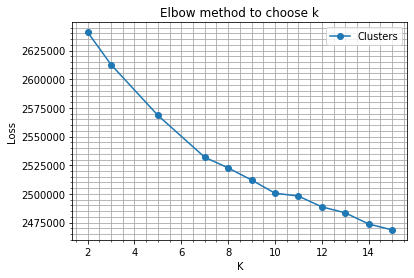

In [0]:
plt.plot(n_clusters, inertia_bow_kmeans, "-o")
plt.title("Elbow method to choose k")
plt.xlabel("K")
plt.ylabel("Loss")
plt.minorticks_on()
plt.legend(['Clusters', 'Inertia'], loc='upper right')
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

So we see sharp fall in loss till n_clusters = 7 , then afterthat it is very much small fall.

**So best n_cluster value is 7**

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [0]:
  best_Kmean_bow_50k_txt = KMeans(n_clusters=7, init='k-means++')
  best_Kmean_bow_50k_txt.fit(bow_X_no_stop_50k_reviews_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
#Plot each cluster features in a cloud
def plot_cluster_cloud(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
    #print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(10, 2, figsize = (30, 20))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 20)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {} word cloud".format(i+1), fontsize = 20)
        ax.axis("off")
    plt.tight_layout()
    fig.subplots_adjust(top = 0.90)
    plt.show()

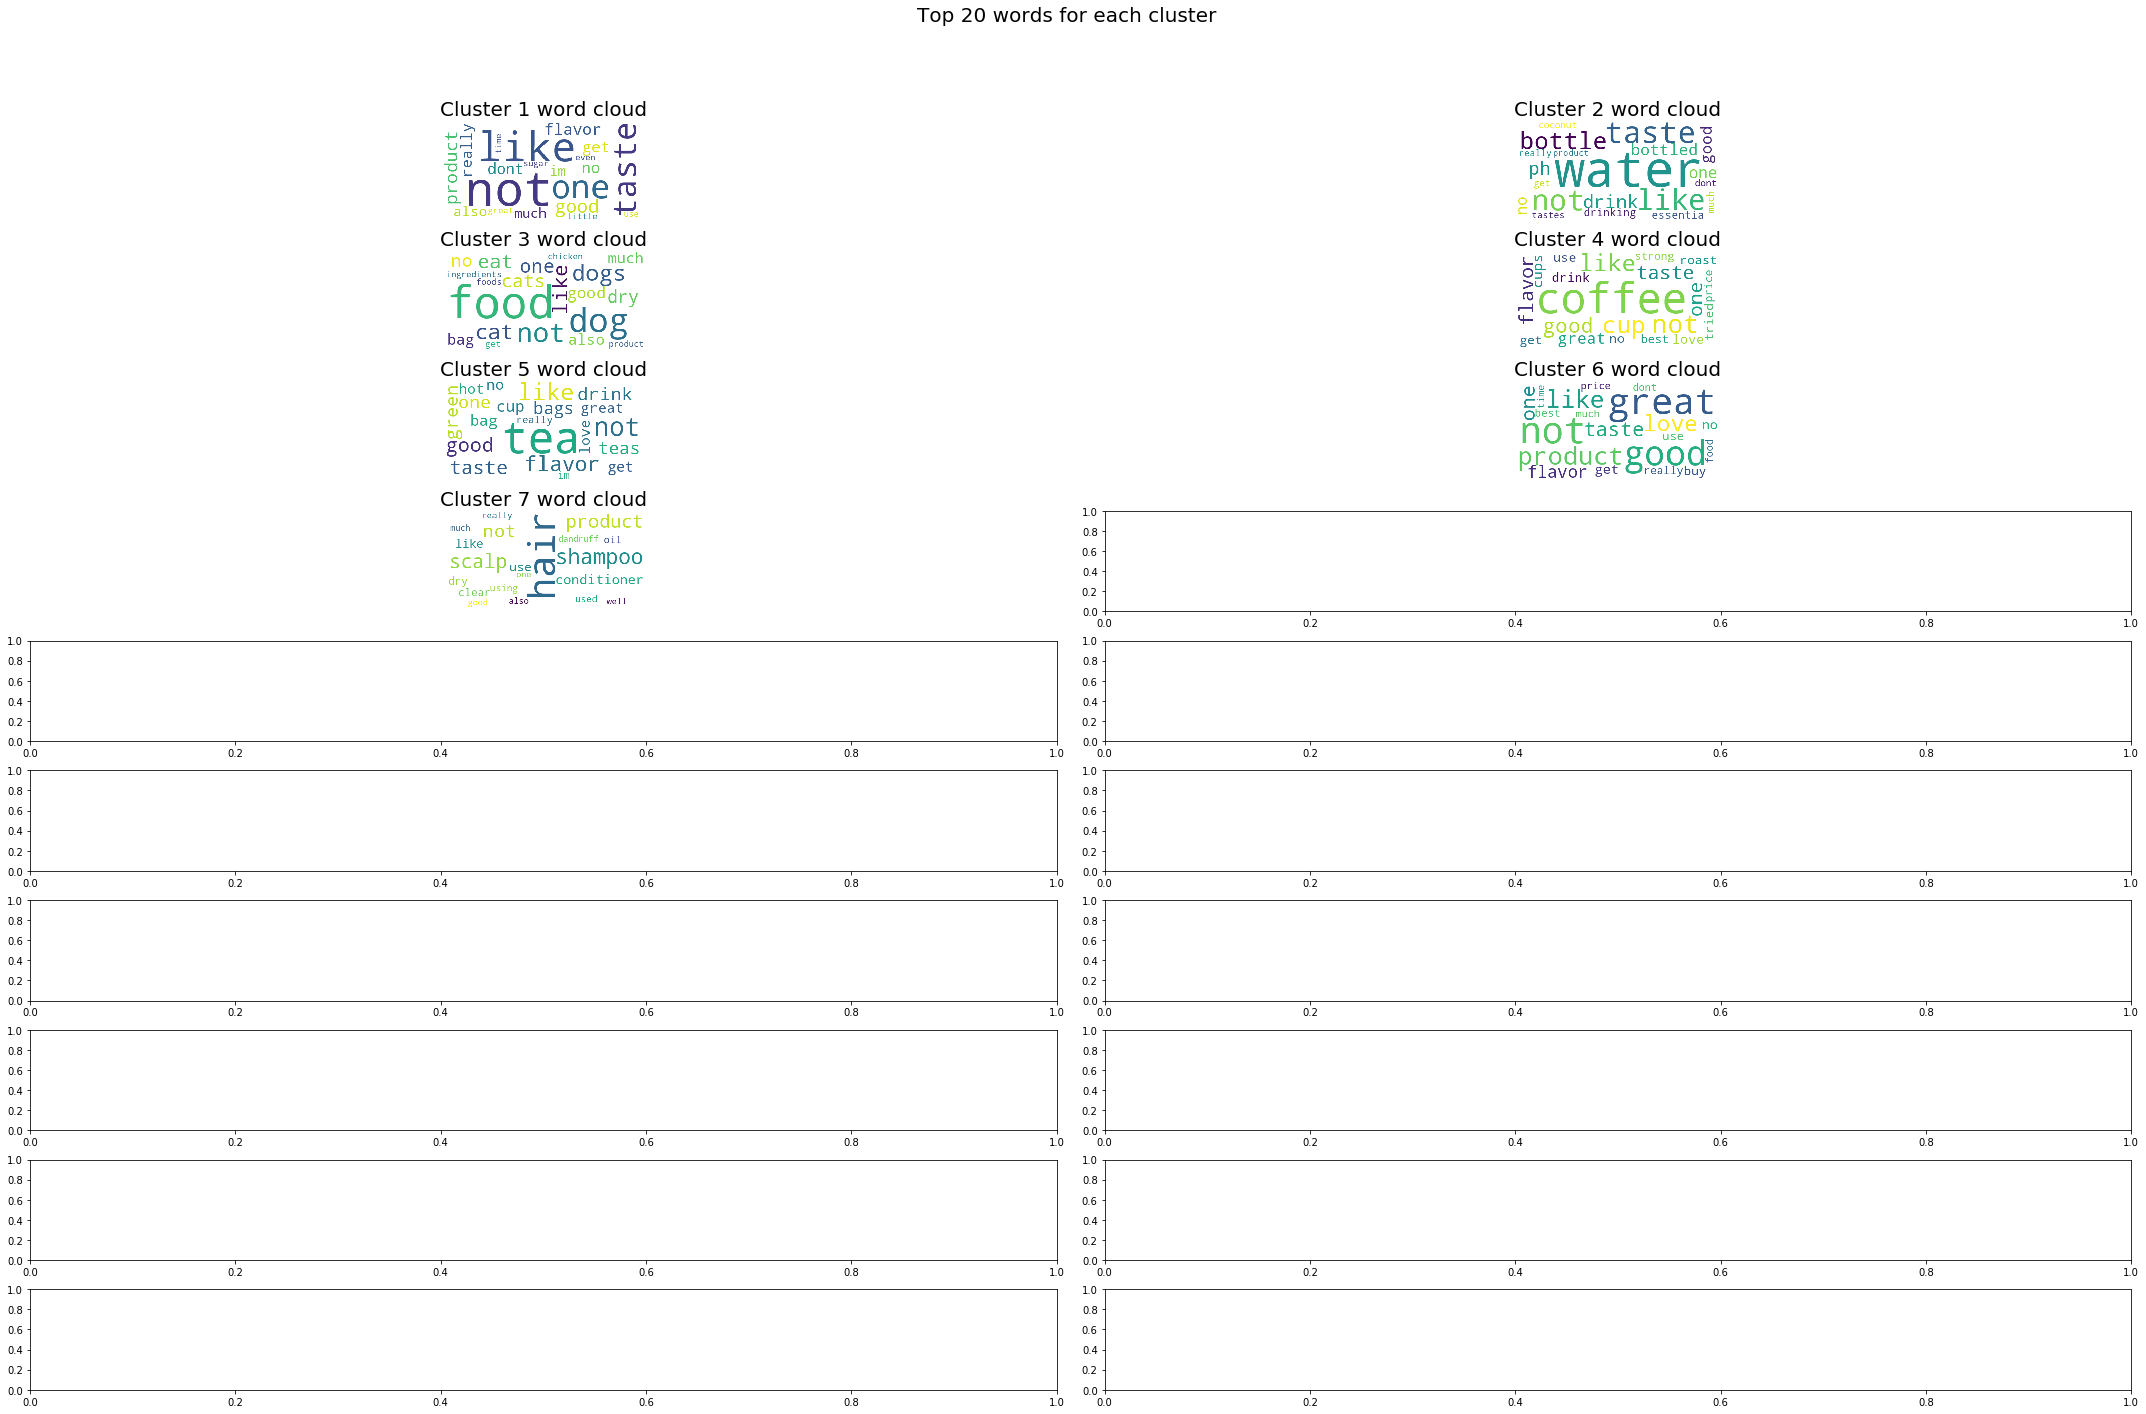

In [0]:
from wordcloud import WordCloud 

features = bow_vect_50K.get_feature_names()
coef = best_Kmean_bow_50k_txt.cluster_centers_
plot_cluster_cloud(features, coef)

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

100%|██████████| 14/14 [3:07:22<00:00, 897.16s/it]


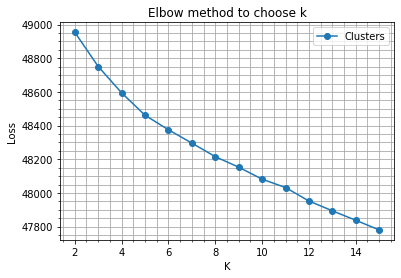

In [44]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=9000)
tfidf_X_no_stop_50k_reviews=tf_idf_vect.fit_transform(X_no_stop_50k_reviews)
tfidf_X_no_stop_50k_reviews_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_X_no_stop_50k_reviews)


from sklearn.cluster import KMeans
inertia_tfidf_kmeans = []
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for n in tqdm(n_clusters):
    Kmean_tfidf_50k_txt = KMeans(n_clusters=n, init='k-means++')
    Kmean_tfidf_50k_txt.fit(tfidf_X_no_stop_50k_reviews_std)
    inertia_tfidf_kmeans.append(Kmean_tfidf_50k_txt.inertia_)

plt.plot(n_clusters, inertia_tfidf_kmeans, "-o")
plt.title("Elbow method to choose k")
plt.xlabel("K")
plt.ylabel("Loss")
plt.minorticks_on()
plt.legend(['Clusters', 'Inertia'], loc='upper right')
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [45]:
  best_Kmean_tfidf_50k_txt = KMeans(n_clusters=7, init='k-means++')
  best_Kmean_tfidf_50k_txt.fit(tfidf_X_no_stop_50k_reviews_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
#Plot each cluster features in a cloud
def plot_cluster_cloud(features, coef):
    coef_df = pd.DataFrame(coef, columns = features)
    #print(len(coef_df))
    # Create a figure and set of 15 subplots because our k range is in between 
    fig, axes = plt.subplots(10, 2, figsize = (30, 20))
    fig.suptitle("Top 20 words for each cluster ", fontsize = 20)
    cent = range(len(coef_df))
    for ax, i in zip(axes.flat, cent):
        wordcloud = WordCloud(background_color = "white").generate_from_frequencies(coef_df.iloc[i,:].sort_values(ascending = False)[0:20])
        ax.imshow(wordcloud)
        ax.set_title("Cluster {} word cloud".format(i+1), fontsize = 20)
        ax.axis("off")
    plt.tight_layout()
    fig.subplots_adjust(top = 0.90)
    plt.show()

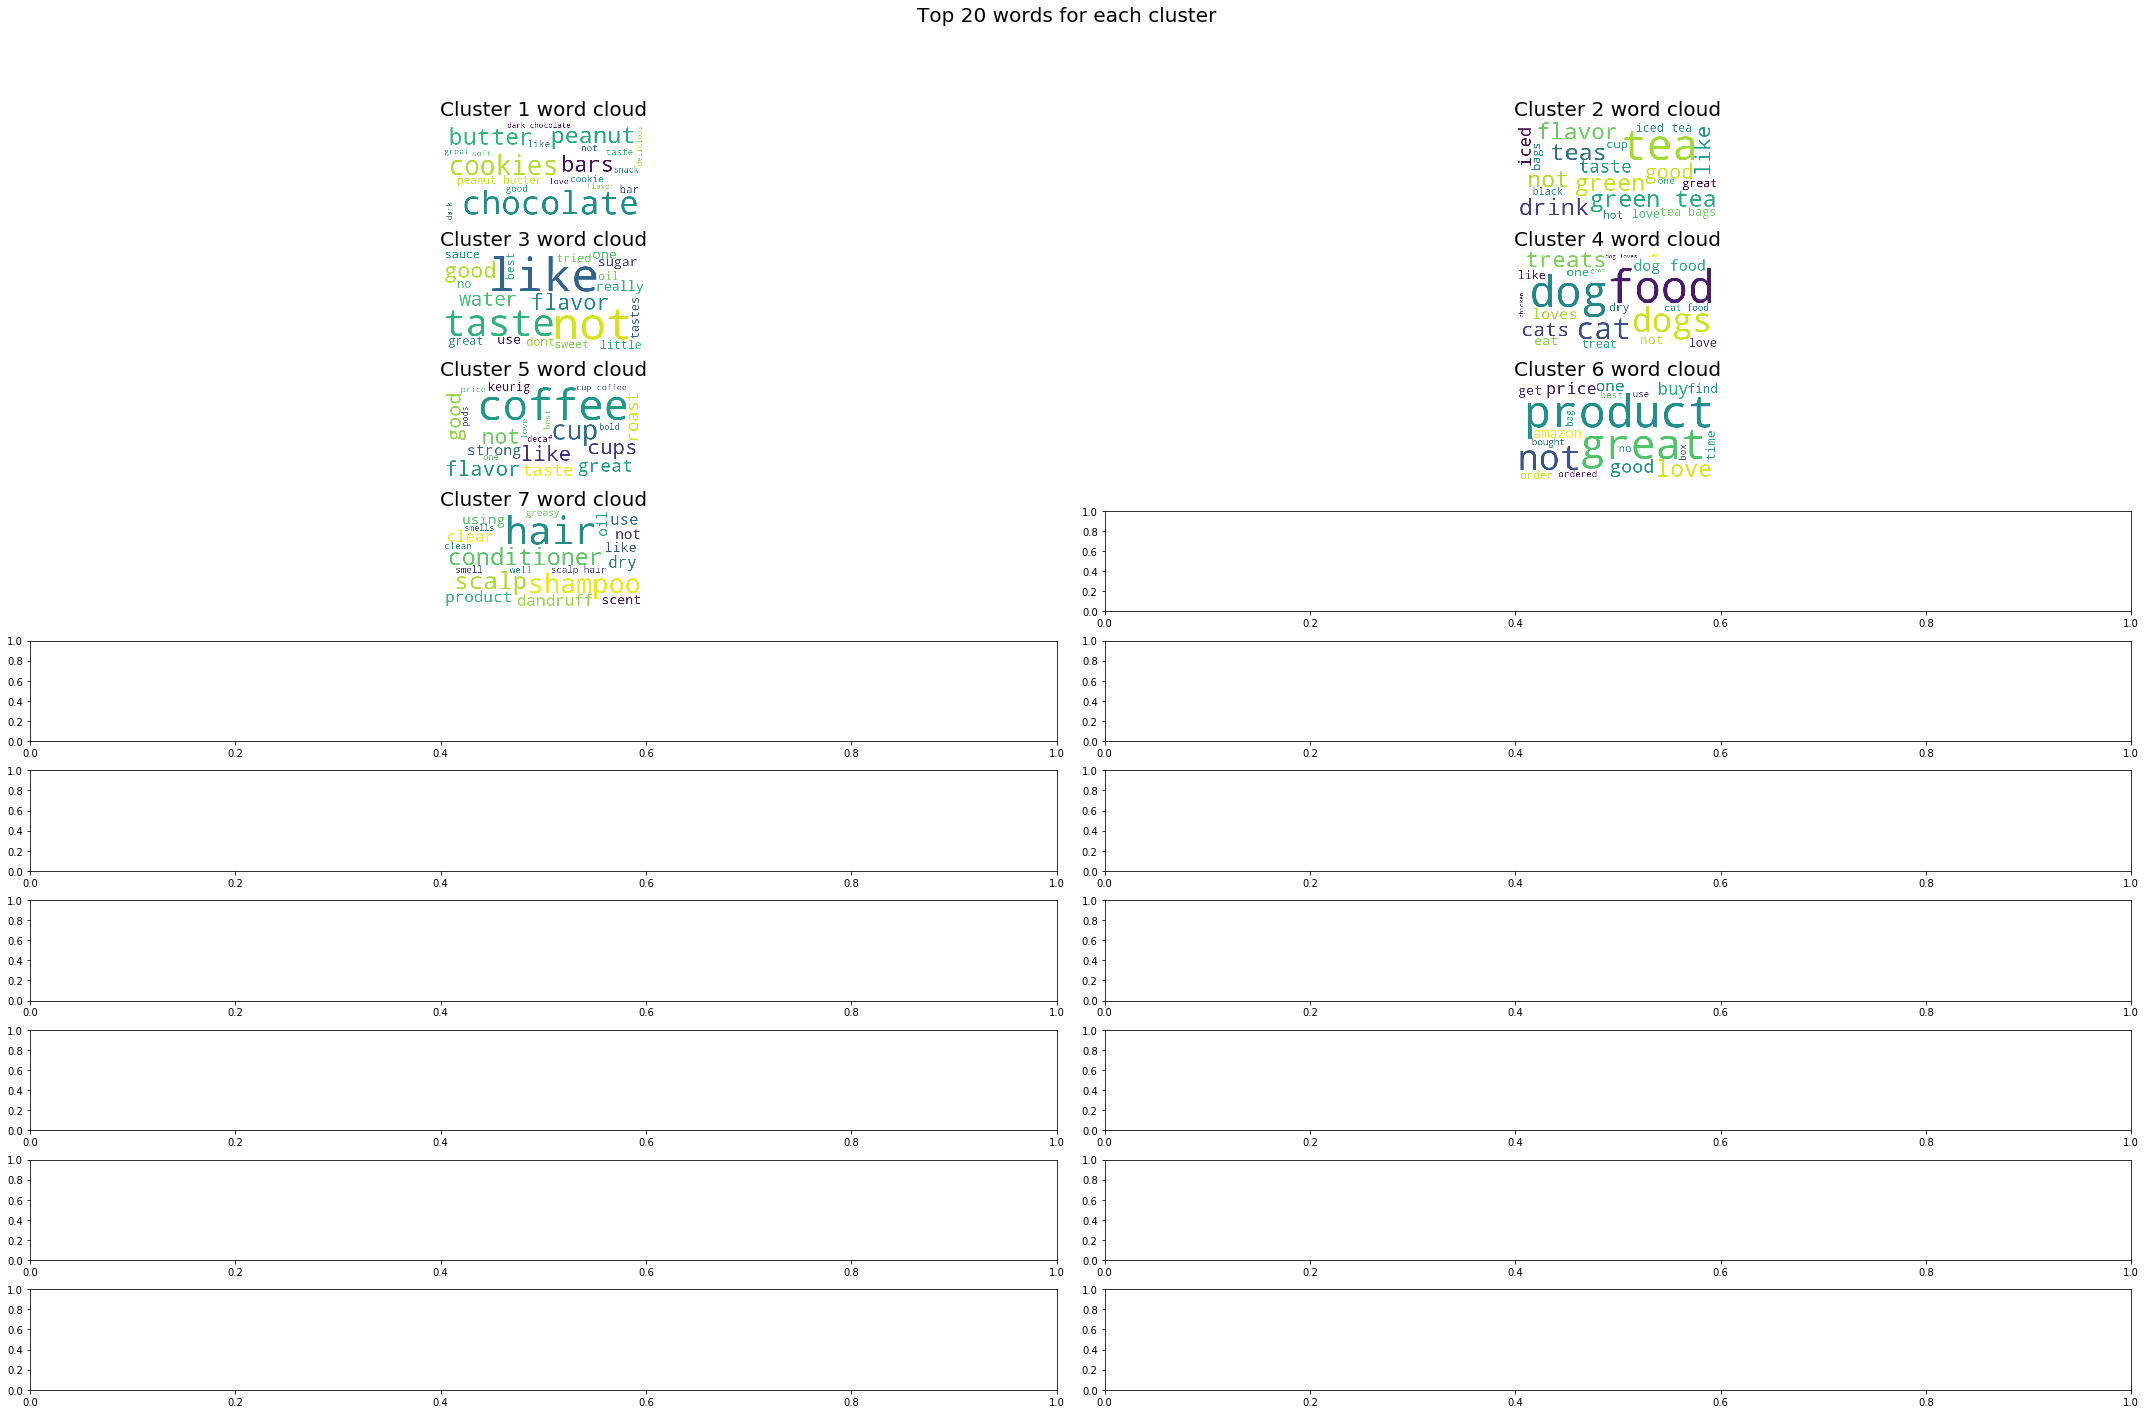

In [47]:
from wordcloud import WordCloud 

features_50K_tfidf = tf_idf_vect.get_feature_names()
coef_50k_tfidf = best_Kmean_tfidf_50k_txt.cluster_centers_
plot_cluster_cloud(features_50K_tfidf, coef_50k_tfidf)

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation


100%|██████████| 14/14 [01:53<00:00, 12.49s/it]


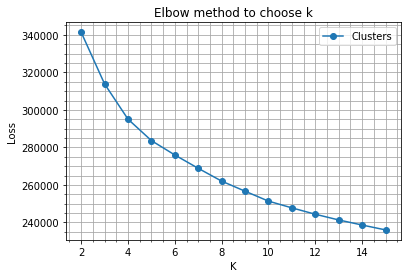

In [0]:
from sklearn.cluster import KMeans

inertia_avgw2v_kmeans = []
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for n in tqdm(n_clusters):
    Kmean_avgw2v_50k_txt = KMeans(n_clusters=n, init='k-means++')
    Kmean_avgw2v_50k_txt.fit(sent_vectors_50K_std)
    inertia_avgw2v_kmeans.append(Kmean_avgw2v_50k_txt.inertia_)

plt.plot(n_clusters, inertia_avgw2v_kmeans, "-o")
plt.title("Elbow method to choose k")
plt.xlabel("K")
plt.ylabel("Loss")
plt.minorticks_on()
plt.legend(['Clusters', 'Inertia'], loc='upper right')
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [59]:
best_Kmean_avgw2v_50k_txt = KMeans(n_clusters=8, init='k-means++')
best_Kmean_avgw2v_50k_txt.fit(sent_vectors_50K_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8=[],[],[],[],[],[],[],[]
for i in range(best_Kmean_avgw2v_50k_txt.labels_.shape[0]):
    if best_Kmean_avgw2v_50k_txt.labels_[i] == 0:
        cluster1.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_avgw2v_50k_txt.labels_[i] == 1:
        cluster2.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_avgw2v_50k_txt.labels_[i] == 2:
        cluster3.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_avgw2v_50k_txt.labels_[i] == 3:
        cluster4.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_avgw2v_50k_txt.labels_[i] == 4:
        cluster5.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_avgw2v_50k_txt.labels_[i] == 5:
        cluster6.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_avgw2v_50k_txt.labels_[i] == 6:
        cluster7.append(X_no_stop_50k_reviews[i]) 
    else:
        cluster8.append(X_no_stop_50k_reviews[i])


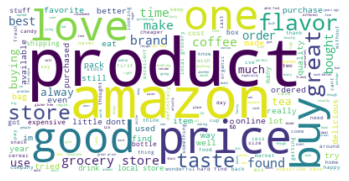

In [61]:

#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

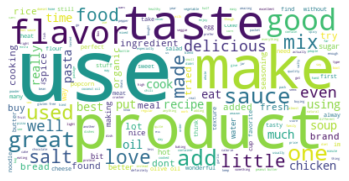

In [62]:

#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

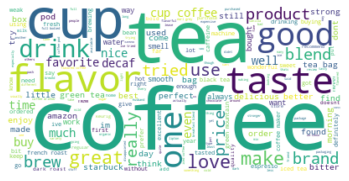

In [63]:

#for cluster 3
data=''
for i in cluster3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

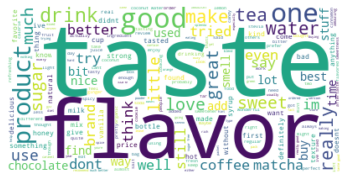

In [64]:

#for cluster 4
data=''
for i in cluster4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

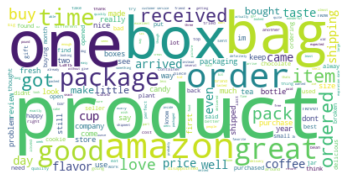

In [65]:

#for cluster 5
data=''
for i in cluster5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

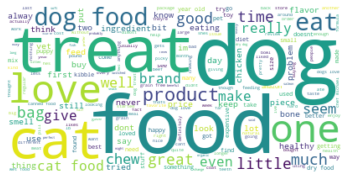

In [66]:

#for cluster 6
data=''
for i in cluster6:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

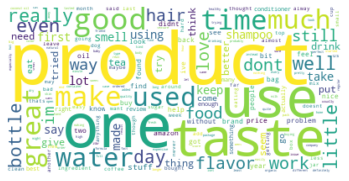

In [67]:

#for cluster 7
data=''
for i in cluster7:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

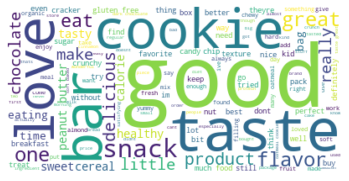

In [68]:

#for cluster 8
data=''
for i in cluster8:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

100%|██████████| 14/14 [01:36<00:00, 11.76s/it]


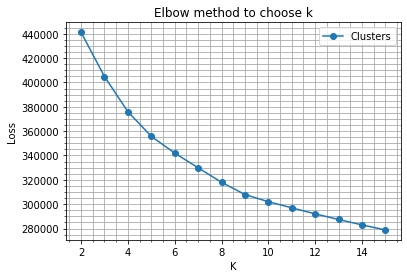

In [0]:
from sklearn.cluster import KMeans

inertia_tfidfw2v_kmeans = []
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for n in tqdm(n_clusters):
    Kmean_tfidfw2v_50k_txt = KMeans(n_clusters=n, init='k-means++')
    Kmean_tfidfw2v_50k_txt.fit(tfidf_w2v_sent_vectors_50k_std)
    inertia_tfidfw2v_kmeans.append(Kmean_tfidfw2v_50k_txt.inertia_)

plt.plot(n_clusters, inertia_tfidfw2v_kmeans, "-o")
plt.title("Elbow method to choose k")
plt.xlabel("K")
plt.ylabel("Loss")
plt.minorticks_on()
plt.legend(['Clusters', 'Inertia'], loc='upper right')
plt.grid(b=True, which='both', color='0.65', linestyle='-')
plt.show()

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [71]:
best_Kmean_tfidfw2v_50k_txt = KMeans(n_clusters=9, init='k-means++')
best_Kmean_tfidfw2v_50k_txt.fit(tfidf_w2v_sent_vectors_50k_std)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9=[],[],[],[],[],[],[],[],[]
for i in range(best_Kmean_tfidfw2v_50k_txt.labels_.shape[0]):
    if best_Kmean_tfidfw2v_50k_txt.labels_[i] == 0:
        cluster1.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_tfidfw2v_50k_txt.labels_[i] == 1:
        cluster2.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_tfidfw2v_50k_txt.labels_[i] == 2:
        cluster3.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_tfidfw2v_50k_txt.labels_[i] == 3:
        cluster4.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_tfidfw2v_50k_txt.labels_[i] == 4:
        cluster5.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_tfidfw2v_50k_txt.labels_[i] == 5:
        cluster6.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_tfidfw2v_50k_txt.labels_[i] == 6:
        cluster7.append(X_no_stop_50k_reviews[i])
    elif best_Kmean_tfidfw2v_50k_txt.labels_[i] == 7:
        cluster8.append(X_no_stop_50k_reviews[i])          
    else:
        cluster9.append(X_no_stop_50k_reviews[i])


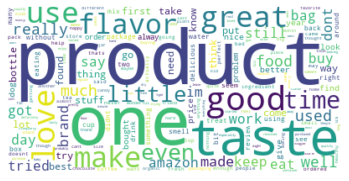

In [73]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

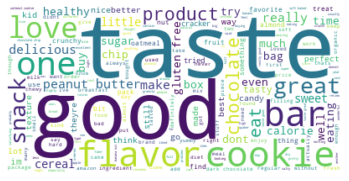

In [74]:

#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

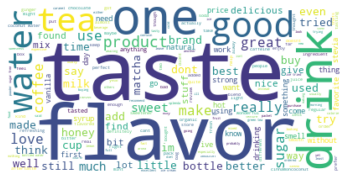

In [75]:

#for cluster 3
data=''
for i in cluster3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

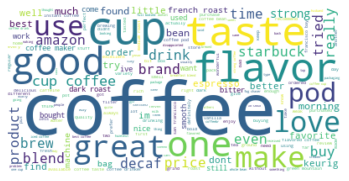

In [76]:

#for cluster 4
data=''
for i in cluster4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

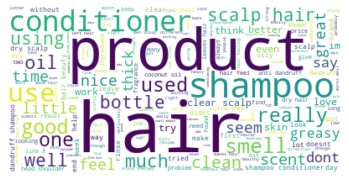

In [77]:

#for cluster 5
data=''
for i in cluster5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

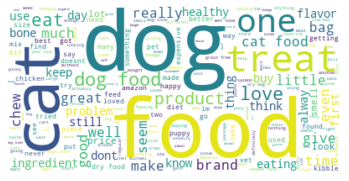

In [78]:

#for cluster 6
data=''
for i in cluster6:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

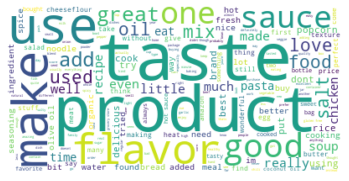

In [79]:

#for cluster 7
data=''
for i in cluster7:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

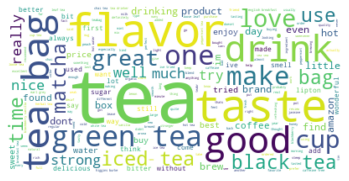

In [80]:

#for cluster 8
data=''
for i in cluster8:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

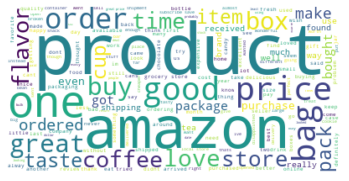

In [81]:
#for cluster 9
data=''
for i in cluster9:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## [5.2] Agglomerative Clustering

In [50]:
lst_5k_reviews=[]
lst_of_lst_5k_review = []

for sent in tqdm(X_no_stop_5k_reviews):
    lst_5k_reviews.append(sent.strip())
for sent in tqdm(lst_5k_reviews):
    lst_of_lst_5k_review.append(sent.split())

w2v_model_self_taught_5K=Word2Vec(lst_of_lst_5k_review,min_count=1,size=50, workers=4)
w2v_words_5K = list(w2v_model_self_taught_5K.wv.vocab)

100%|██████████| 5000/5000 [00:00<00:00, 45616.64it/s]


In [51]:
sent_vectors_5K = []
for sent6 in tqdm(lst_of_lst_5k_review): # for each review/sentence
    sent_vec6 = np.zeros(50)
    cnt_words6 = 0
    for word6 in sent6:
        if word6 in w2v_words_5K:
            vec6 = w2v_model_self_taught_5K.wv[word6]
            sent_vec6 += vec6
            cnt_words6 += 1
    if cnt_words6 != 0:
        sent_vec6 /= cnt_words6
    sent_vectors_5K.append(sent_vec6) 

100%|██████████| 5000/5000 [00:06<00:00, 767.02it/s]


In [0]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sent_vectors_5K_std = StandardScaler(with_mean=False,with_std=False).fit_transform(sent_vectors_5K)


In [54]:
model_5k = TfidfVectorizer()
model_5k.fit(X_no_stop_5k_reviews)
dictionary_5k = dict(zip(model_5k.get_feature_names(), list(model_5k.idf_)))

tfidf_feat_5k = model_5k.get_feature_names() # tfidf words/col-names

tfidf_w2v_sent_vectors_5k = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent7 in tqdm(lst_of_lst_5k_review): # for each review/sentence 
    sent_vec7 = np.zeros(50) # as word vectors are of zero length
    weight_sum7 =0; # num of words with a valid vector in the sentence/review
    for word7 in sent7: # for each word in a review/sentence
        if word7 in w2v_words_5K and word7 in tfidf_feat_5k:
            vec7 = w2v_model_self_taught_5K.wv[word7]
            tf_idf_5k = dictionary_5k[word7]*(sent7.count(word7)/len(sent7))
            sent_vec7 += (vec7 * tf_idf_5k)
            weight_sum7 += tf_idf_5k
    if weight_sum7 != 0:
        sent_vec7 /= weight_sum7
    tfidf_w2v_sent_vectors_5k.append(sent_vec7)
    row += 1

100%|██████████| 5000/5000 [00:40<00:00, 122.35it/s]


In [0]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

tfidf_w2v_sent_vectors_5k_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_5k)


### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.cluster import AgglomerativeClustering

aggclus_avgw2v_5k_txt_cluster2=AgglomerativeClustering(n_clusters=2).fit(sent_vectors_5K_std)
aggclus_avgw2v_5k_txt_cluster5=AgglomerativeClustering(n_clusters=5).fit(sent_vectors_5K_std)

For k =2 clusters

In [0]:
cluster1,cluster2=[],[]
for i in range(aggclus_avgw2v_5k_txt_cluster2.labels_.shape[0]):
    if aggclus_avgw2v_5k_txt_cluster2.labels_[i] == 0:
        cluster1.append(X_no_stop_5k_reviews[i])
    else:
        cluster2.append(X_no_stop_5k_reviews[i])

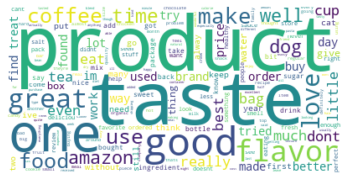

In [20]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

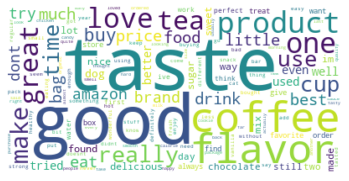

In [23]:
#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

For K =5

In [0]:
cluster1,cluster2,cluster3,cluster4,cluster5=[],[],[],[],[]
for i in range(aggclus_avgw2v_5k_txt_cluster5.labels_.shape[0]):
    if aggclus_avgw2v_5k_txt_cluster5.labels_[i] == 0:
        cluster1.append(X_no_stop_5k_reviews[i])
    elif aggclus_avgw2v_5k_txt_cluster5.labels_[i] == 1:
        cluster2.append(X_no_stop_5k_reviews[i])
    elif aggclus_avgw2v_5k_txt_cluster5.labels_[i] == 2:
        cluster3.append(X_no_stop_5k_reviews[i])
    elif aggclus_avgw2v_5k_txt_cluster5.labels_[i] == 3:
        cluster4.append(X_no_stop_5k_reviews[i])
    else:
        cluster5.append(X_no_stop_5k_reviews[i])



### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

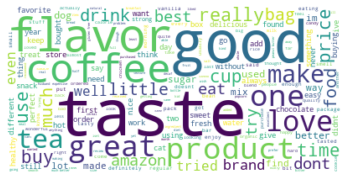

In [25]:
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

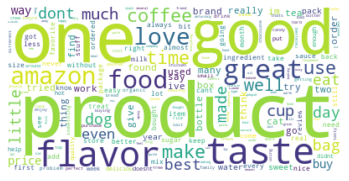

In [26]:
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

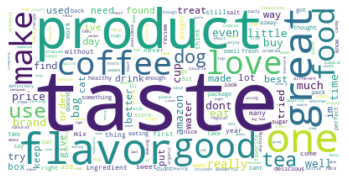

In [27]:
data=''
for i in cluster3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

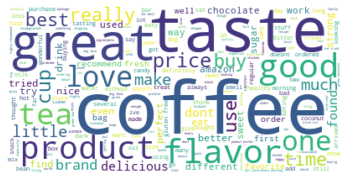

In [28]:
data=''
for i in cluster4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

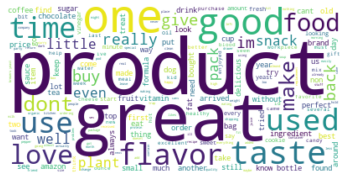

In [29]:
data=''
for i in cluster5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [87]:
model_5k = TfidfVectorizer()
model_5k.fit(X_no_stop_5k_reviews)
dictionary_5k = dict(zip(model_5k.get_feature_names(), list(model_5k.idf_)))

tfidf_feat_5k = model_5k.get_feature_names() # tfidf words/col-names

tfidf_w2v_sent_vectors_5k = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent7 in tqdm(lst_of_lst_5k_review): # for each review/sentence 
    sent_vec7 = np.zeros(50) # as word vectors are of zero length
    weight_sum7 =0; # num of words with a valid vector in the sentence/review
    for word7 in sent7: # for each word in a review/sentence
        if word7 in w2v_words_5K and word7 in tfidf_feat_5k:
            vec7 = w2v_model_self_taught_5K.wv[word7]
            tf_idf_5k = dictionary_5k[word7]*(sent7.count(word7)/len(sent7))
            sent_vec7 += (vec7 * tf_idf_5k)
            weight_sum7 += tf_idf_5k
    if weight_sum7 != 0:
        sent_vec7 /= weight_sum7
    tfidf_w2v_sent_vectors_5k.append(sent_vec7)
    row += 1

100%|██████████| 5000/5000 [00:33<00:00, 151.40it/s]


In [0]:
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

tfidf_w2v_sent_vectors_5k_std =StandardScaler(with_mean=False,with_std=False).fit_transform(tfidf_w2v_sent_vectors_5k)


In [0]:
from sklearn.cluster import AgglomerativeClustering

aggclus_tfidf_5k_txt_cluster2=AgglomerativeClustering(n_clusters=2).fit(tfidf_w2v_sent_vectors_5k_std)
aggclus_tfidf_5k_txt_cluster5=AgglomerativeClustering(n_clusters=5).fit(tfidf_w2v_sent_vectors_5k_std)

For k =2 clusters

In [0]:
cluster1,cluster2=[],[]
for i in range(aggclus_tfidf_5k_txt_cluster2.labels_.shape[0]):
    if aggclus_tfidf_5k_txt_cluster2.labels_[i] == 0:
        cluster1.append(X_no_stop_5k_reviews[i])
    else:
        cluster2.append(X_no_stop_5k_reviews[i])

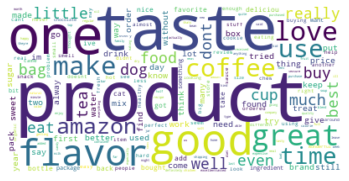

In [34]:
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

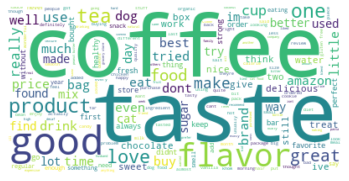

In [35]:
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

For K =5

In [0]:
cluster1,cluster2,cluster3,cluster4,cluster5=[],[],[],[],[]
for i in range(aggclus_tfidf_5k_txt_cluster5.labels_.shape[0]):
    if aggclus_tfidf_5k_txt_cluster5.labels_[i] == 0:
        cluster1.append(X_no_stop_5k_reviews[i])
    elif aggclus_tfidf_5k_txt_cluster5.labels_[i] == 1:
        cluster2.append(X_no_stop_5k_reviews[i])
    elif aggclus_tfidf_5k_txt_cluster5.labels_[i] == 2:
        cluster3.append(X_no_stop_5k_reviews[i])
    elif aggclus_tfidf_5k_txt_cluster5.labels_[i] == 3:
        cluster4.append(X_no_stop_5k_reviews[i])
    else:
        cluster5.append(X_no_stop_5k_reviews[i])



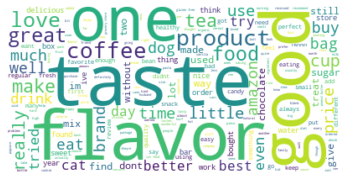

In [37]:
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

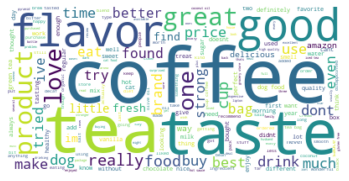

In [38]:
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

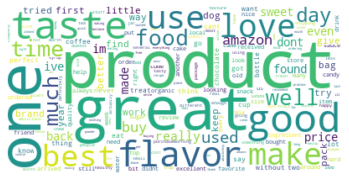

In [39]:
data=''
for i in cluster3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

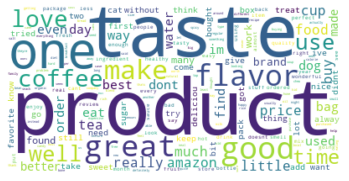

In [40]:
data=''
for i in cluster4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

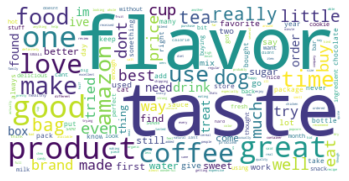

In [41]:
data=''
for i in cluster5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [0]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
min_point = 100
knn = NearestNeighbors(n_neighbors = min_point)
knn.fit(sent_vectors_5K_std)
dist , index = knn.kneighbors(sent_vectors_5K_std)

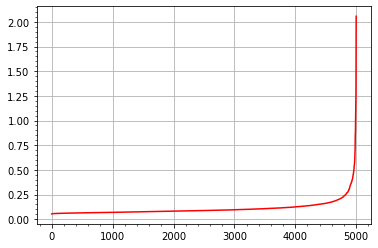

In [72]:
sort = sorted(dist[:,min_point-1])
plt.plot(list(range(1,len(sent_vectors_5K_std)+1)),sort,'r-')
plt.minorticks_on()
plt.grid()
plt.show()

In [73]:
dbscan_avgw2v_5k_txt = DBSCAN(eps = .25 , min_samples = 100)
dbscan_avgw2v_5k_txt.fit(sent_vectors_5K_std)

print('No of clusters: ',len(set(dbscan_avgw2v_5k_txt.labels_)))


No of clusters:  2


In [79]:
print((dbscan_avgw2v_5k_txt.labels_).shape)

(5000,)


### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [0]:
cluster1,cluster2=[],[]

for i in range(dbscan_avgw2v_5k_txt.labels_.shape[0]):
    if dbscan_avgw2v_5k_txt.labels_[i] == 0:
        cluster1.append(sent_vectors_5K_std[i])
    else:
        cluster2.append(sent_vectors_5K_std[i])


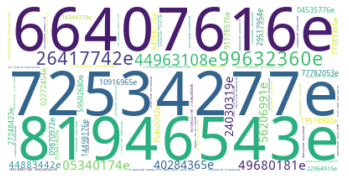

In [101]:
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


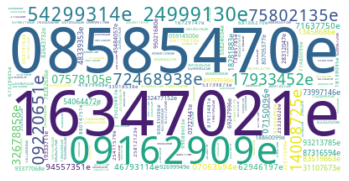

In [102]:
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

Now MINPTS should be more than d+1 and around range of 2*d. SO here MINPts=100

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

https://github.com/Manish-12/Clustering-Techniques-on-Amazon-fine-food-reviews/blob/master/DBSCAN.ipynb


In [0]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
min_point = 100
knn = NearestNeighbors(n_neighbors = min_point)
knn.fit(sent_vectors_5K_std)
dist , index = knn.kneighbors(tfidf_w2v_sent_vectors_5k_std)

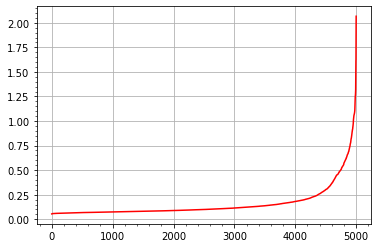

In [90]:
sort = sorted(dist[:,min_point-1])
plt.plot(list(range(1,len(tfidf_w2v_sent_vectors_5k_std)+1)),sort,'r-')
plt.minorticks_on()
plt.grid()
plt.show()

Seems .25 is the best EPS

In [103]:
dbscan_tfidfw2v_5k_txt = DBSCAN(eps = .25 , min_samples = 100)
dbscan_tfidfw2v_5k_txt.fit(tfidf_w2v_sent_vectors_5k_std)

print('No of clusters: ',len(set(dbscan_tfidfw2v_5k_txt.labels_)))

No of clusters:  2


### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

In [0]:
cluster1,cluster2=[],[]

for i in range(dbscan_tfidfw2v_5k_txt.labels_.shape[0]):
    if dbscan_tfidfw2v_5k_txt.labels_[i] == 0:
        cluster1.append(tfidf_w2v_sent_vectors_5k_std[i])
    else:
        cluster2.append(tfidf_w2v_sent_vectors_5k_std[i])


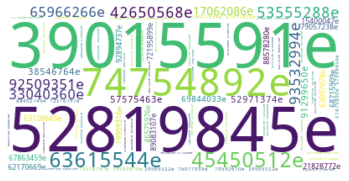

In [105]:
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

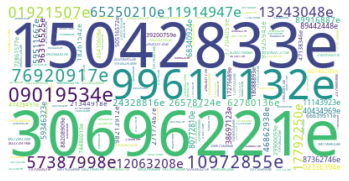

In [106]:
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# [6] Conclusions

In [95]:
# Please compare all your models using Prettytable library. 
# You can have 3 tables, one each for kmeans, agllomerative and dbscan

print ("Pretty Table for K-Means")
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Best k"]
x.add_row(['BOW','7'])
x.add_row(['TFIDF','7'])
x.add_row(['AVG W2vec','8'])
x.add_row(['TFIDF W2vec','9'])
print(x)

Pretty Table for K-Means
+-------------+--------+
|  Vectorizer | Best k |
+-------------+--------+
|     BOW     |   7    |
|    TFIDF    |   7    |
|  AVG W2vec  |   8    |
| TFIDF W2vec |   9    |
+-------------+--------+


K Means seems to have work well. If we give lesser number of clusters it still custers well and if we give more it still clusters well with more granular information

In [96]:
print ("Pretty Table for DBSCAN")
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","EPS"]
x.add_row(['AVG W2vec','.25'])
x.add_row(['TFIDF W2vec','.25'])
print(x)

Pretty Table for DBSCAN
+-------------+-----+
|  Vectorizer | EPS |
+-------------+-----+
|  AVG W2vec  | .25 |
| TFIDF W2vec | .25 |
+-------------+-----+


It didnt do well unless i have made some mistake would request team to please check

I would like to again point out most of the code i borrowed from other students github profile as i wasn;t able to perform wordcloud task